In [1]:
#Standard python imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Stats imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

#random seed for replicability
np.random.seed(seed=42)

In [2]:
chi_df = pd.read_csv('../data/chi_df_cleaned.csv')
chi_df.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_22,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
0,2,42.30596,-87.96015,42.306916,-87.960918,0.077,37.0,31.0,79.0,29.59,...,0,0,0,0,0,0,0,0,0,0
1,2,42.17587,-88.13577,42.174620,-88.135794,0.086,37.0,28.1,76.0,29.62,...,0,0,0,0,0,0,0,0,0,0


## Research Hypotheses 

For the purposes of answering our problem statement on the impact of the fall and spring time changes associated with Daylight Savings Time (DST), we have created two sets of research hypotheses:
* For the spring time change:
    * H0: There is not a statistically significant difference in the average severity of accidents in Chicago in the weeks before, during, and after the spring time change.
    * Ha: There is a statistically significant difference in the average severity of accidents in Chicago in the weeks before, during, and after the spring time change.
* For the fall time change:
    * H0: There is not a statistically significant difference in the average severity of accidents in Chicago in the weeks before, during, and after the fall time change.
    * Ha: There is a statistically significant difference in the average severity of accidents in Chicago in the weeks before, during, and after the fall time change.
    
To test each research hypothesis we will run an ANOVA for the severity of accidents on the week before, week of, and week after each time change. Our alpha for each test will be set as 0.05, meaning that a p-value <0.05 would be considered significant and a rejection of the null hypothesis.

For the spring time change those weeks are respectively:
* Week 10 as the week prior to the time change.
* Week 11 as the week of the time change.
* Week 12 as the week after the time change.

For the fall time change those weeks are respectively:
* Week 44 as the week prior to the time change.
* Week 45 as the week of the time change. 
* Week 46 as the week after the time change.

## ANOVA on Severity of Chi Accidents for Spring DST Time Change

In [3]:
#We referenced this article for a refresher on ANOVA and to find the libraries to use for each test
#https://www.pythonfordatascience.org/anova-python/#anova-test
#We referenced these pages for a refresher on ANOVA vs. Kruskall-Wallis and the impact of a non-normal distribution
# https://stats.stackexchange.com/questions/76059/difference-between-anova-and-kruskal-wallis-test
# http://www.biostathandbook.com/kruskalwallis.html

In [4]:
#Spring DST Time Change ANOVA
stats.f_oneway(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

F_onewayResult(statistic=8.688793448084233, pvalue=0.00017439777178230329)

In [5]:
chi_df_spring_dst =  chi_df[(chi_df['week'] == 10) | (chi_df['week'] == 11) | (chi_df['week'] == 12)]
chi_df_spring_dst['week'].value_counts()

11    918
12    714
10    540
Name: week, dtype: int64

In [6]:
#Statsmodel ANOVA for cleaner tables and use in multiple comparison tests
chi_spring_anova = ols("severity ~C(week)", data=chi_df_spring_dst).fit()
chi_spr_aov_table = sm.stats.anova_lm(chi_spring_anova, typ=2)
chi_spr_aov_table

,sum_sq,df,F,PR(>F)
C(week),6.234790,2.0,8.688793,0.000174
Residual,778.201214,2169.0,NaN,NaN


In [7]:
#Levene's test of homogeneity, 
#non-significant meaning the weeks have non-significant differences in their variability
stats.levene(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

LeveneResult(statistic=2.2096940010363624, pvalue=0.10998119275827695)

In [8]:
#Shapiro test of normality, failed as the severity of accidents is not normally distributed
stats.shapiro(chi_spring_anova.resid)

ShapiroResult(statistic=0.8185059428215027, pvalue=3.363116314379561e-44)

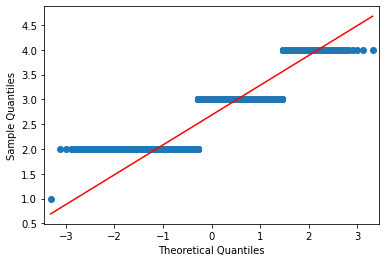

In [9]:
#QQ plot to conform lack of normality
sm.qqplot(chi_df_spring_dst['severity'], line='s');

The above tests of normality illustrate that the distribution of accident severity is non-normal. Due to this we have also ran the Kruskal-Wallis non-parametric test which is an ANOVA analog, as normality is an assumption of ANOVA.

With that said some statisticians find that violating the assumption of normality is not very impactful on changing the rate of type-1 errors or false positives. One argument for this point of view is from John H. Macdonald [here](http://www.biostathandbook.com/kruskalwallis.html) .

For the purposes of this project we have ran both ANOVA and Kruskal-Wallis when testing our research hypotheses.

In [10]:
#Spring DST Time Change Kruskall-Wallic
stats.kruskal(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

KruskalResult(statistic=16.609003084980962, pvalue=0.000247400632235319)

In [11]:
eta_square = chi_spr_aov_table[:-1]['sum_sq'] / sum(chi_spr_aov_table['sum_sq'])
eta_square

C(week)    0.007948
Name: sum_sq, dtype: float64

### Interpretation
* The results of the above ANOVA and Kruskal-Wallis tests on accident severity for the spring time change show strong  evidence for statistical significance as both p-values (KW = 0.0002, ANOVA = 0.0001) are smaller then our alpha of 0.05. 
* Given this we can reject our null hypothesis and state that there is a statistically significant difference in the average severity of accidents in Chicago during the weeks before, during, and after the fall time change.
* In addition to the ANOVA and Kruskal-Wallis we also calculated the Eta squared effect size, finding that the effect of the difference found was of a small size at eta = 0.008.

## Multiple Comparison Tests

### Tukey Honestly Significant Difference (HSD) Test

In [12]:
#Updating the weeks to wording of week before, of, after for ease of table reading.
chi_df_spring_dst['week'] = chi_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})
chi_df_spring_dst['week'].value_counts()

<ipython-input-12-2f3d9b8e17f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_df_spring_dst['week'] = chi_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})


Week of DST    918
Week After     714
Week Before    540
Name: week, dtype: int64

In [13]:
comp = mc.MultiComparison(chi_df_spring_dst['severity'], chi_df_spring_dst['week'], 
                         group_order=['Week Before', 'Week of DST', 'Week After'])
post_hoc = comp.tukeyhsd()
post_hoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Week Before,Week of DST,-0.1329,0.001,-0.2091,-0.0567,True
Week Before,Week After,-0.0618,0.1672,-0.1419,0.0183,False
Week of DST,Week After,0.0711,0.0459,0.001,0.1412,True


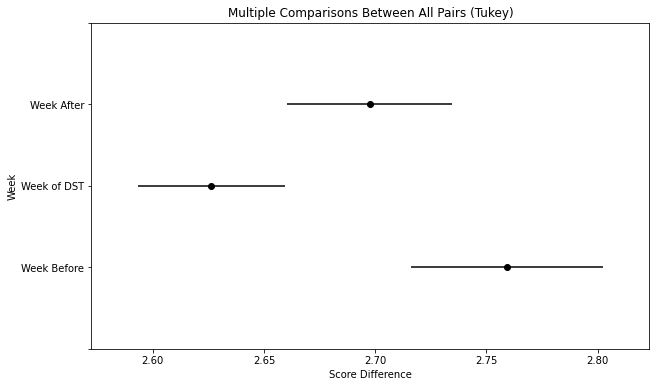

In [14]:
post_hoc.plot_simultaneous(ylabel='Week', xlabel='Score Difference');

### Bonferroni Correction

In [15]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='bonf')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,4.0866,0.0,0.0001,True
Week Before,Week After,1.7884,0.0739,0.2218,False
Week of DST,Week After,-2.4028,0.0164,0.0491,True


### Sidak Correction 

In [16]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='sidak')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,4.0866,0.0,0.0001,True
Week Before,Week After,1.7884,0.0739,0.2058,False
Week of DST,Week After,-2.4028,0.0164,0.0483,True


In [17]:
print(chi_df_spring_dst['week'].value_counts())

Week of DST    918
Week After     714
Week Before    540
Name: week, dtype: int64


### Interpretation
* Based on the results from each multiple comparisons test we can see that there is a significant difference in severity score between:
    * the week before DST and the week of DST, with higher severity in the week before DST
    * and the week of DST and the week after DST, with higher severity in the week after DST.
* These results are somewhat counter to what might be expected, however this could be due to the differences in overall accidents for each week as the week of DST had 200 more than the week after and almost 400 more than the week before. More accidents could be lowering the impact of the most sever accidents.

## ANOVA on Severity of Chi Accidents for the Fall DST Time Change

In [18]:
#Fall DST Time Change ANOVA
stats.f_oneway(chi_df['severity'][chi_df['week'] == 44],
              chi_df['severity'][chi_df['week'] == 45],
              chi_df['severity'][chi_df['week'] == 46])

F_onewayResult(statistic=0.20600694424410165, pvalue=0.8138414290480289)

In [19]:
#Fall DST Time Change Kruskall-Wallace
stats.kruskal(chi_df['severity'][chi_df['week'] == 44],
              chi_df['severity'][chi_df['week'] == 45],
              chi_df['severity'][chi_df['week'] == 46])

KruskalResult(statistic=0.023728434732062008, pvalue=0.9882058849505668)

### Interpretation
The results of the above ANOVA and Kruskal-Wallis tests on accident severity for the fall time change do not show evidence for statistical significance as neither p-value (0.81, 0.99) are smaller then our alpha set at 0.05. Due to this we cannot reject our null hypothesis that there is not a statistically significant difference in the average severity of accidents in Chicago during the weeks before, during, and after the fall time change.